# MDL Phase Diagrams for Spatio-Temporal Motif Detectability

This notebook computes and visualizes detectability frontiers for spatio-temporal motifs under an MDL framework. It implements the core equations:

- Baseline per-spike cost: $c_s = \log_2(T/\Delta) + \log_2 N$
- Start-time cost: $c_{start} = \log_2(T/\Delta)$
- Jitter cost: $c_{jit} = \log_2(1+2\tau/\Delta)$
- Dictionary cost: $L_{dict} \approx m(\log_2(W/\Delta)+\log_2 N)$
- MDL frontier: $K > \frac{L_{dict}}{m c_s - c_{start} - m c_{jit}}$
- Visible effect frontier: add $\eta S c_s$ to numerator.

It also supports an observation fraction $p$ for subsampling.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from math import log2
import pandas as pd

# Parameters
N = 100
T_sec = 1800.0
Delta_ms = 1.0
W_ms = 50.0
taus_ms = [1.0, 2.0, 5.0]
etas = [0.002, 0.005, 0.01]
m_range = np.arange(3, 41)
S_total = 9*10**5
p_obs = 1.0

T_bins = T_sec * 1000.0 / Delta_ms
W_bins = W_ms / Delta_ms

print(f"Setup: N={N}, T={T_sec}s, Δ={Delta_ms}ms, W={W_ms}ms, S≈{S_total}, p={p_obs}")


Setup: N=100, T=1800.0s, Δ=1.0ms, W=50.0ms, S≈900000, p=1.0


In [2]:

def cs_bits(T_bins, N):
    return log2(T_bins) + log2(N)

def cstart_bits(T_bins):
    return log2(T_bins)

def cjit_bits(tau_ms, Delta_ms):
    return log2(1.0 + 2.0*tau_ms/Delta_ms)

def Ldict_bits(m_obs, W_bins, N):
    return m_obs*(log2(W_bins)+log2(N))

def K_star_mdl_positive(m, T_bins, W_bins, N, tau_ms, Delta_ms, p=1.0):
    m_obs = max(p*m, 1e-9)
    cs = cs_bits(T_bins, N)
    cstart = cstart_bits(T_bins)
    cjit = cjit_bits(tau_ms, Delta_ms)
    num = Ldict_bits(m_obs, W_bins, N)
    den = (m_obs*cs) - cstart - (m_obs*cjit)
    return np.inf if den <= 0 else num/den

def K_star_visible(m, T_bins, W_bins, N, tau_ms, Delta_ms, eta, S_total, p=1.0):
    m_obs = max(p*m, 1e-9)
    cs = cs_bits(T_bins, N)
    cstart = cstart_bits(T_bins)
    cjit = cjit_bits(tau_ms, Delta_ms)
    num = Ldict_bits(m_obs, W_bins, N) + eta*S_total*cs
    den = (m_obs*cs) - cstart - (m_obs*cjit)
    return np.inf if den <= 0 else num/den


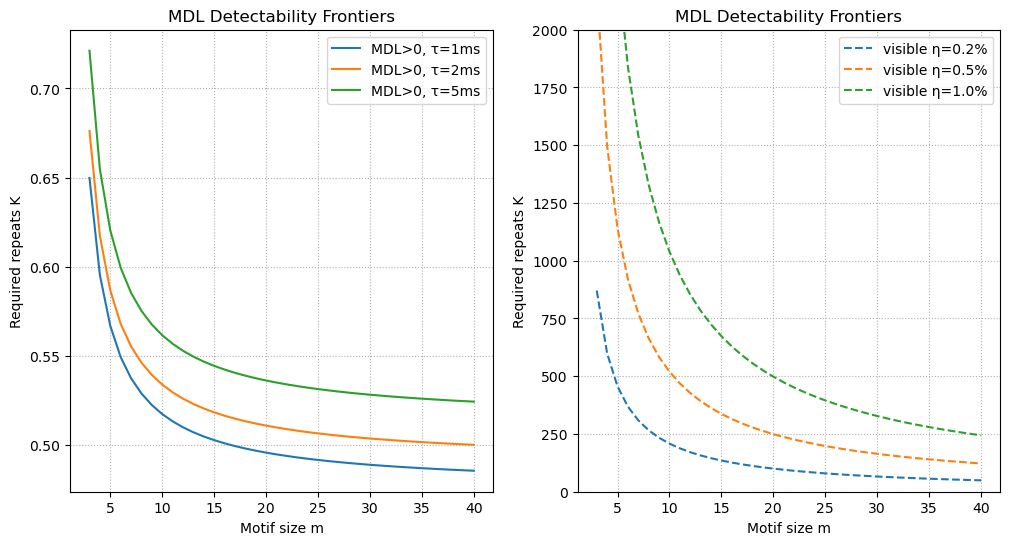

In [14]:

def plot_phase_diagram(m_values, taus_ms, etas, T_bins, W_bins, N, Delta_ms, S_total, p_obs=1.0, ymax=2000):
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    for tau in taus_ms:
        Kpos = [K_star_mdl_positive(m, T_bins, W_bins, N, tau, Delta_ms, p_obs) for m in m_values]
        ax[0].plot(m_values, Kpos, label=f"MDL>0, τ={tau:.0f}ms")
    for eta in etas:
        Kvis = [K_star_visible(m, T_bins, W_bins, N, taus_ms[0], Delta_ms, eta, S_total, p_obs) for m in m_values]
        ax[1].plot(m_values, Kvis, linestyle="--", label=f"visible η={eta*100:.1f}%")
    ax[1].set_ylim(0, ymax)
    [_ax.set_xlabel("Motif size m") for _ax in ax]
    [_ax.set_ylabel("Required repeats K") for _ax in ax]
    [_ax.set_title("MDL Detectability Frontiers") for _ax in ax]
    [_ax.legend() for _ax in ax]
    [_ax.grid(True, linestyle=":") for _ax in ax]
    plt.show()

plot_phase_diagram(m_range, taus_ms, etas, T_bins, W_bins, N, Delta_ms, S_total, p_obs=p_obs)


In [4]:

def lookup_table(m_list, tau_list, eta_list, T_bins, W_bins, N, Delta_ms, S_total, p_obs=1.0):
    rows = []
    for m in m_list:
        for tau in tau_list:
            Kpos = K_star_mdl_positive(m, T_bins, W_bins, N, tau, Delta_ms, p_obs)
            for eta in eta_list:
                Kvis = K_star_visible(m, T_bins, W_bins, N, tau, Delta_ms, eta, S_total, p_obs)
                rows.append({"m": m, "tau_ms": tau,
                             "K*_MDL>0": np.ceil(Kpos) if np.isfinite(Kpos) else np.inf,
                             f"K*_η={eta*100:.1f}%": np.ceil(Kvis) if np.isfinite(Kvis) else np.inf})
    return pd.DataFrame(rows)

lookup_table([6,10,20,30], taus_ms, etas, T_bins, W_bins, N, Delta_ms, S_total, p_obs)


,m,tau_ms,K*_MDL>0,K*_η=0.2%,K*_η=0.5%,K*_η=1.0%
0,6,1.0,1.0,369.0,NaN,NaN
1,6,1.0,1.0,NaN,920.0,NaN
2,6,1.0,1.0,NaN,NaN,1839.0
3,6,2.0,1.0,381.0,NaN,NaN
4,6,2.0,1.0,NaN,952.0,NaN
5,6,2.0,1.0,NaN,NaN,1902.0
6,6,5.0,1.0,402.0,NaN,NaN
7,6,5.0,1.0,NaN,1004.0,NaN
8,6,5.0,1.0,NaN,NaN,2008.0
9,10,1.0,1.0,209.0,NaN,NaN
